In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)


In [2]:
data_dir = r"F:\Image\Projet\Images" 
img_size = (300, 300)       
batch_size = 8
num_classes = 120


# tf.keras.mixed_precision.set_global_policy("mixed_float16")


In [12]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, subset="training", seed=1337,
    image_size=img_size, batch_size=batch_size
)
val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, subset="validation", seed=1337,
    image_size=img_size, batch_size=batch_size
)

class_names = train_ds_raw.class_names
print(f"{len(class_names)} classes détectées.")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds_raw.prefetch(AUTOTUNE)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
120 classes détectées.


In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


In [5]:
base = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, input_shape=img_size + (3,), weights="imagenet"
)
base.trainable = False

inputs = keras.Input(shape=img_size + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet_v2.preprocess_input(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(num_classes, activation="softmax", dtype="float32")(x) 
model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[keras.metrics.TopKCategoricalAccuracy(k=1, name="top1"),
             keras.metrics.TopKCategoricalAccuracy(k=5, name="top5")]
)


In [6]:
def to_one_hot(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_oh = train_ds.map(to_one_hot)
val_ds_oh = val_ds.map(to_one_hot)


In [7]:
ckpt = keras.callbacks.ModelCheckpoint("best_head.keras", monitor="val_top1", mode="max",
                                       save_best_only=True, verbose=1)
es = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="val_top1", mode="max")
rlrp = keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2, monitor="val_loss")

history = model.fit(
    train_ds_oh, validation_data=val_ds_oh, epochs=5,
    callbacks=[ckpt, es, rlrp]
)


Epoch 1/5
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 2.2604 - top1: 0.6363 - top5: 0.8412
Epoch 1: val_top1 improved from None to 0.87755, saving model to best_head.keras
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 485s 229ms/step - loss: 1.6757 - top1: 0.7652 - top5: 0.9435 - val_loss: 1.2318 - val_top1: 0.8776 - val_top5: 0.9930 - learning_rate: 0.0010
Epoch 2/5
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 1.2869 - top1: 0.8673 - top5: 0.9874
Epoch 2: val_top1 improved from 0.87755 to 0.88192, saving model to best_head.keras
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 465s 224ms/step - loss: 1.3054 - top1: 0.8565 - top5: 0.9869 - val_loss: 1.2179 - val_top1: 0.8819 - val_top5: 0.9913 - learning_rate: 0.0010
Epoch 3/5
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 1.2266 - top1: 0.8878 - top5: 0.9930
Epoch 3: val_top1 improved from 0.88192 to 0.88703, saving model to best_head.keras
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 465s 225ms/step - loss: 1.2436 - top1: 0.8813 - top5: 0.9913 - val_loss: 1

In [8]:
base.trainable = True
for layer in base.layers[:-50]:  
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # plus petit LR
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[keras.metrics.TopKCategoricalAccuracy(k=1, name="top1"),
             keras.metrics.TopKCategoricalAccuracy(k=5, name="top5")]
)

ckpt_ft = keras.callbacks.ModelCheckpoint("best_finetune.keras", monitor="val_top1", mode="max",
                                          save_best_only=True, verbose=1)
es_ft = keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor="val_top1", mode="max")

history_ft = model.fit(
    train_ds_oh, validation_data=val_ds_oh, epochs=5,
    callbacks=[ckpt_ft, es_ft, rlrp]
)


Epoch 1/5
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - loss: 1.3605 - top1: 0.8168 - top5: 0.9750
Epoch 1: val_top1 improved from None to 0.88095, saving model to best_finetune.keras
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 680s 322ms/step - loss: 1.2650 - top1: 0.8285 - top5: 0.9763 - val_loss: 0.8448 - val_top1: 0.8810 - val_top5: 0.9913 - learning_rate: 1.0000e-05
Epoch 2/5
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - loss: 1.0931 - top1: 0.8516 - top5: 0.9833
Epoch 2: val_top1 improved from 0.88095 to 0.88581, saving model to best_finetune.keras
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 647s 313ms/step - loss: 1.0693 - top1: 0.8547 - top5: 0.9853 - val_loss: 0.8245 - val_top1: 0.8858 - val_top5: 0.9925 - learning_rate: 1.0000e-05
Epoch 3/5
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - loss: 1.0219 - top1: 0.8631 - top5: 0.9866
Epoch 3: val_top1 improved from 0.88581 to 0.88678, saving model to best_finetune.keras
2058/2058 ━━━━━━━━━━━━━━━━━━━━ 641s 310ms/step - loss: 1.0129 - top1: 0.8650 - top5: 

In [9]:

model.evaluate(val_ds_oh)


515/515 ━━━━━━━━━━━━━━━━━━━━ 88s 171ms/step - loss: 0.8335 - top1: 0.8914 - top5: 0.9927


[0.8334715962409973, 0.8913994431495667, 0.9927113652229309]

In [21]:

from tensorflow import keras
model = keras.models.load_model("best_finetune.keras") 


In [22]:
import tensorflow as tf
import numpy as np
from PIL import Image

def load_and_preprocess_image(image_path, img_size=(300, 300)):
    img = Image.open(image_path).convert("RGB").resize(img_size)
    x = np.array(img, dtype=np.float32)
    x = tf.keras.applications.efficientnet_v2.preprocess_input(x)  
    x = np.expand_dims(x, axis=0) 
    return x

def predict_image(image_path, top_k=5):
    x = load_and_preprocess_image(image_path, img_size=img_size)
    preds = model.predict(x, verbose=0)[0] 
    top_indices = preds.argsort()[-top_k:][::-1]
    top_scores = preds[top_indices]
    top_labels = [class_names[i] for i in top_indices]
    
    best_idx = int(top_indices[0])
    best_label = class_names[best_idx]
    best_score = float(top_scores[0])
    
    return {
        "top1_label": best_label,
        "top1_score": best_score,
        "topk": [
            {"label": lbl, "score": float(score), "index": int(idx)}
            for lbl, score, idx in zip(top_labels, top_scores, top_indices)
        ]
    }


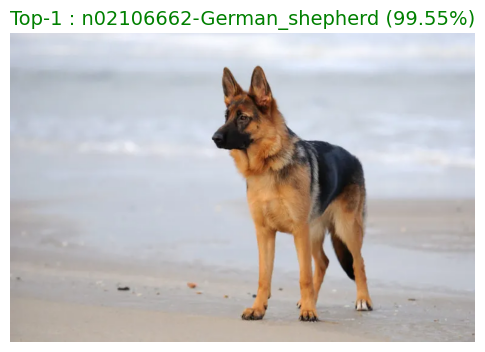

Top-5 prédictions :
 - n02106662-German_shepherd      99.55%
 - n02105162-malinois             0.08%
 - n02109961-Eskimo_dog           0.02%
 - n02115641-dingo                0.02%
 - n02091467-Norwegian_elkhound   0.01%


In [32]:
import matplotlib.pyplot as plt

def plot_prediction(image_path, result):
    img = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Top-1 : {result['top1_label']} ({result['top1_score']:.2%})", fontsize=14, color="green")
    plt.show()

    print("Top-5 prédictions :")
    for r in result["topk"]:
        print(f" - {r['label']:30s} {r['score']:.2%}")

img_path = r"berger.webp"
result = predict_image(img_path, top_k=5)
plot_prediction(img_path, result)
